# Classification of emails using Shorttext library

This notebook will test the different classification methods offered by the Shorttext library.

---
__Organization:__
1. Put the csv file in the right format for shorttext model and split the data between train and test
2. Preprocess the text
3. Train a LDA model and make classification using topics found
4. Use a Word2Vec representation of words and make classification

__What is left to be done:__
1. Put the csv file in the right format for shorttext model and split the data between train and test<br>
-- Change "Fatou_relabeled" by the final dataframe

2. Preprocess the text<br>
-- Try stemming

3. Train a LDA model and make classification using topics found<br>
3.1. Train a LDA model and make classification using topics found<br>
---- Choose the right number of topics (try different values for k and keep the value that gives the highest cross-validation score (http://scikit-learn.org/stable/modules/cross_validation.html)<br>
3.3. Classify using Scikit-Learn Classifiers<br>
---- Try different SKLearn classifiers (GaussianNB, GradientBoostingClassifier, etc..)<br>
---- Optimize parameters for classifiers (for example for RandomForestClassifier, change number of trees)

4. Use a Word2Vec representation of words and make classification<br>
4.3. Classify using a Convolutional Neural Network
---- Optimize parameters for the CNN (number of epochs, size, etc...) => check Shorttext github<br>
---- Try a double CNN<br>

4.4. Classify using a C-LSTM Neural Network<br>
---- Optimize parameters for the C-LSTM (number of epochs, size, etc...) => check Shorttext github<br>

- <strong>What can be tested also:</strong> 
- Try metrics different than accuracy like f1-score, precision, etc.
- Make a comparison of all methods
- Add useful graphs

__Keep in mind:__

Unfortunately, it only works with Python 2. You can create a Python 2 environment using conda <br>see here => https://conda.io/docs/user-guide/tasks/manage-environments.html#creating-an-environment-with-commands

In [1]:
# !pip install -U shorttext
# !pip install -U spacy
# !spacy download en
import pandas as pd
import operator
import re
from nltk.corpus import stopwords

import shorttext
from shorttext.utils import text_preprocessor
from shorttext.utils import load_word2vec_model

from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#import seaborn as sns
#%matplotlib inline

Using TensorFlow backend.


In [2]:
import keras
keras.__version__

'2.1.5'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
#Helper functions

def predict(classifier, mail):
    #function that takes a message and a shorttext classifer then predict the category associated
    probas = classifier.score(mail)
    category = max(probas.iteritems(), key=operator.itemgetter(1))[0]
    return(category)


def create_df_from_dict(dictionary, categories):
    #create a dataframe with columns "Label" and "Message" from the shorttext dictionary
    df = pd.DataFrame()
    for cat in categories :
        class_size = len(dictionary[cat])
        labels = pd.Series([cat]*class_size)
        messages = pd.Series(dictionary[cat])
        tmp = pd.concat([pd.DataFrame(labels),pd.Series(messages)],axis=1)
        tmp.columns = ["Label", "Message"]
        df = pd.concat([df,tmp],axis=0)
    return df

# 1. Put the csv file in the right format for shorttext model and split the data between train and test

The file has to obey these rules:

- there is a heading; and
- there are at least two columns: first the labels, and second the short text under the labels (everything being the second column will be neglected).

In [50]:
df = pd.read_csv("../data/recombined.csv")

In [51]:
#we add the catgegories names
categories = ["miscl.", "conflicts", "attendance", "assignments", "enrollment", "internal", "dsp", "regrades"]
df["Label"] = df.Category.apply(lambda cat : categories[cat-1])

In [52]:
#Concatenate the body and the subject
df["Message"] = df["Subject"] + " " + df["Body"]

In [53]:
df.fillna("", inplace = True)

In [54]:
#split the data between train and test
def stratified_train_test_split(X, y, test_size, seed):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    return X_train, X_test, y_train, y_test

In [133]:
test_size = 0.3
seed = 42
X_train, X_test, y_train, y_test = stratified_train_test_split(df["Message"], df["Label"], test_size, seed)
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)

('X_train.shape', (1064,))
('X_test.shape', (456,))


In [134]:
print("Classes proportions in train set")
print(y_train.value_counts(normalize=True))
print("")
print("Classes proportions in test set")
print(y_test.value_counts(normalize=True))

Classes proportions in train set
miscl.         0.379699
assignments    0.212406
conflicts      0.132519
enrollment     0.106203
dsp            0.069549
attendance     0.047932
internal       0.033835
regrades       0.017857
Name: Label, dtype: float64

Classes proportions in test set
miscl.         0.379386
assignments    0.212719
conflicts      0.131579
enrollment     0.105263
dsp            0.070175
attendance     0.048246
internal       0.032895
regrades       0.019737
Name: Label, dtype: float64


In [57]:
#final training dataframe
train = pd.concat([y_train, X_train],axis=1)
train.columns = ["Label", "Message"]
train.to_csv("../data/train_set_in_shorttext_format.csv", index=False)
train.head()

,Label,Message
710,assignments,Re: HW2 forgot to attach screenshot of IPython...
1192,assignments,Re: Self-Grade hw 8 turned in at 12:02 am grad...
418,dsp,Re: DSP thanks for your email! please let me k...
647,assignments,"Re: iPython Submission hi jodie, unfortunate..."
668,assignments,"Minutes Late HW hello ms. li, yesterday,..."


In [58]:
#final test dataframe
test = pd.concat([y_test, X_test],axis=1)
test.columns = ["Label", "Message"]
test.to_csv("../data/test_set_in_shorttext_format.csv", index=False)
test.head()

,Label,Message
156,enrollment,Re: Graduating Senior: Enrollment from Waitlis...
950,miscl.,"Lab 109 GSI email? hi, i am an eecs 47d stude..."
685,attendance,"Re: Lab excuse hi sarah, we have buffer weeks..."
788,assignments,"Re: Uploading Homework problem hi youdong, i ..."
484,miscl.,"Re: EE Final Exam , thank you so much this wo..."


# 2. Preprocess the text

- remove punctuation
- lemmatize words
- put to lower cases
- remove stop words

In [52]:
#dictionary where key = "category" and value = list of emails in that category
trainclassdict = shorttext.data.retrieve_csvdata_as_dict('../data/train_set_in_shorttext_format.csv')
testclassdict = shorttext.data.retrieve_csvdata_as_dict('../data/test_set_in_shorttext_format.csv')

In [17]:
eng_stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

#preprocessing functions
step1fcn = lambda s: re.sub("[^a-zA-Z]", " ", s)
step2fcn = lambda s: ' '.join(map(lambda word: lemmatizer.lemmatize(word), s.split(' ')))
step3fcn = lambda s: s.lower()
step4fcn = lambda s: re.sub(' +',' '," ".join([word for word in s.split(" ") if not word in eng_stopwords]))

#pipeline
pipeline = [step1fcn, step2fcn, step3fcn, step4fcn]
preprocessor = text_preprocessor(pipeline)

In [18]:
text = "  Maryland blue had crab in, having Annapolis dogs!"
preprocessor(text)

u' maryland blue crab annapolis dog '

In [1]:
#Example of cleaning
#cat = "conflicts"
#print("Before : {}".format(trainclassdict[cat][0]))
#print("")
#print("After: {}".format(preprocessor(trainclassdict[cat][0])))

In [20]:
#clean the train data
for cat in categories :
    class_size = len(trainclassdict[cat])
    for i in range(class_size):
        trainclassdict[cat][i] = preprocessor(trainclassdict[cat][i])

#clean the test data       
for cat in categories :
    class_size = len(testclassdict[cat])
    for i in range(class_size):
        testclassdict[cat][i] = preprocessor(testclassdict[cat][i])

In [21]:
#create dataframe for train and test
train = create_df_from_dict(trainclassdict, categories)
test = create_df_from_dict(testclassdict, categories)

# 3. Classify with LDA model 

- We train a LDA model with k number of topics (k can be determined by cross-validation)
- The LDA model converts every text to a vector
- The cos classifier compute the cosinus between the vector representing the text and the vector representing the label
- The sklearn classifer uses the coefficients of the vector as features

__Reference__: http://shorttext.readthedocs.io/en/latest/tutorial_topic.html

## 3.1. Train the LDA model

In [25]:
#https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
topicmodeler = shorttext.generators.LDAModeler()

In [27]:
num_topics = 7
topicmodeler.train(trainclassdict, num_topics)

In [219]:
example = 'exam conflict hi based school policy offering additional accommodation option involved club sport conflict exam time staff member time midterm exam may proctored staff member supervising let know would like take accommodation thanks'

In [29]:
#topic vector representation
topicmodeler.retrieve_topicvec(example)

array([ 0.04721192,  0.99328852,  0.04722582,  0.04722619,  0.04722399,
        0.04721523,  0.04721208])

## 3.2. Classify using cosine similarity

### 3.2.1 Train the model

In [30]:
cos_classifier = shorttext.classifiers.TopicVectorCosineDistanceClassifier(topicmodeler)

In [31]:
#predictions
cos_classifier.score(example)

{'assignments': 0.047225755,
 'attendance': 0.99328852,
 'conflicts': 0.99328852,
 'dsp': 0.074214183,
 'enrollment': 0.047211919,
 'internal': 0.066969566,
 'miscl.': 0.047225755,
 'regrades': 0.065808013}

In [32]:
predict(cos_classifier, example)

'attendance'

### 3.2.2. Accuracy on train and test set

In [33]:
train_preds = train.Message.apply(lambda x : predict(cos_classifier, x))
train_accuracy = sum(train_preds == train.Label)/float(len(train))
print("Accuracy:", train_accuracy)

('Accuracy:', 0.44905660377358492)


In [34]:
test_preds = test.Message.apply(lambda x : predict(cos_classifier, x))
test_accuracy = sum(test_preds == test.Label)/float(len(test))
print("Accuracy:", test_accuracy)

('Accuracy:', 0.40618101545253865)


## 3.3. Classify using Scikit-Learn Classifiers

In [36]:
sklearn_classifier = RandomForestClassifier()

In [37]:
classifier = shorttext.classifiers.TopicVectorSkLearnClassifier(topicmodeler, sklearn_classifier)

In [39]:
import numpy as np
X = []
y = []
classlabels = trainclassdict.keys()
for classidx, classlabel in zip(range(len(classlabels)), classlabels):
    topicvecs = map(topicmodeler.retrieve_topicvec, trainclassdict[classlabel])
    if(np.any(np.isnan(topicvecs))):
        i, _ = np.where(np.isnan(topicvecs))
        print(i)
        print(trainclassdict[classlabel][i[0]])
        print(topicmodeler.retrieve_topicvec(trainclassdict[classlabel][i[0]]))
    X += topicvecs
    y += [classidx]*len(topicvecs)

In [40]:
classifier = shorttext.classifiers.TopicVectorSkLearnClassifier(topicmodeler, sklearn_classifier)
classifier.train(trainclassdict)

In [41]:
#predictions
classifier.score(example)

{'assignments': 0.0,
 'attendance': 0.0,
 'conflicts': 0.0,
 'dsp': 0.0,
 'enrollment': 0.0,
 'internal': 0.0,
 'miscl.': 1.0,
 'regrades': 0.0}

In [42]:
predict(classifier, example)

'miscl.'

In [43]:
train_preds = train.Message.apply(lambda x : predict(classifier, x))
train_accuracy = sum(train_preds == train.Label)/float(len(train))
print("Accuracy:", train_accuracy)

('Accuracy:', 0.95188679245283014)


In [44]:
train_confusion_matrix = pd.DataFrame(confusion_matrix(train.Label, train_preds, labels=categories), columns=categories, index=categories)
train_confusion_matrix

,miscl.,conflicts,attendance,assignments,enrollment,internal,dsp,regrades
miscl.,374,3,0,21,0,0,2,0
conflicts,7,134,0,0,0,0,0,0
attendance,0,2,49,0,0,0,0,0
assignments,11,0,0,215,0,0,0,0
enrollment,2,0,0,0,111,0,0,0
internal,0,1,0,0,0,35,0,0
dsp,0,0,0,0,0,0,74,0
regrades,2,0,0,0,0,0,0,17


In [47]:
test_preds = test.Message.apply(lambda x : predict(classifier, x))
test_accuracy = sum(test_preds == test.Label)/float(len(test))
print("Accuracy:", test_accuracy)

('Accuracy:', 0.54605263157894735)


In [48]:
test_confusion_matrix = pd.DataFrame(confusion_matrix(test.Label, test_preds, labels=categories), columns=categories, index=categories)
test_confusion_matrix

,miscl.,conflicts,attendance,assignments,enrollment,internal,dsp,regrades
miscl.,96,9,3,48,6,1,8,2
conflicts,19,27,8,4,0,0,2,0
attendance,5,10,4,1,0,1,1,0
assignments,28,2,0,65,1,0,1,0
enrollment,17,3,1,8,17,1,0,1
internal,4,0,0,1,0,10,0,0
dsp,4,2,1,1,0,0,24,0
regrades,3,0,0,0,0,0,0,6


# 4. Classify with Word2Vec model 

- We load the previously trained Word2Vec model by Google 
- We try a classifer that represent a text as the sum of vectors of words
- The cos classifier compute the cosinus between the vector representing the text and the vector representing the label
- The sklearn classifer uses the coefficients of the vector as features

__Reference__: http://shorttext.readthedocs.io/en/latest/tutorial_sumvec.html

## 4.1. Load the Word2Vec model

In [23]:
wvmodel = load_word2vec_model('../../GoogleNews-vectors-negative300.bin')

## 4.2 Classify using shorttext.classifiers.SumEmbeddedVecClassifier
This classifier :
- represents the text as a vector which is the sum of vectors representing words
- compute the cosinus between this vector and the vector of the labels

__Reference__: http://shorttext.readthedocs.io/en/latest/tutorial_sumvec.html

### 4.2.1 Train the model

In [40]:
#we should look for the file
classifier = shorttext.classifiers.SumEmbeddedVecClassifier(wvmodel)   
classifier.train(trainclassdict)

In [41]:
#predictions
classifier.score(example)

{'assignments': 0.75667980249759181,
 'attendance': 0.74388712807114454,
 'conflicts': 0.83576537017207309,
 'dsp': 0.79370996192096444,
 'enrollment': 0.77134426783243604,
 'internal': 0.78528928847073021,
 'miscl.': 0.77228307115211425,
 'regrades': 0.71426779882606695}

In [42]:
predict(classifier, example)

'conflicts'

### 4.2.2. Accuracy on train and test set

In [43]:
train_preds = train.Message.apply(lambda x : predict(classifier, x))
train_accuracy = sum(train_preds == train.Label)/float(len(train))
print("Accuracy:", train_accuracy)

('Accuracy:', 0.64245283018867927)


In [44]:
train_confusion_matrix = pd.DataFrame(confusion_matrix(train.Label, train_preds, labels=categories), columns=categories, index=categories)
train_confusion_matrix

,miscl.,conflicts,attendance,assignments,enrollment,internal,dsp,regrades
miscl.,159,56,31,54,25,27,25,23
conflicts,12,124,0,1,1,0,3,0
attendance,5,1,41,0,3,0,0,1
assignments,23,1,6,180,8,3,1,4
enrollment,9,4,11,0,85,3,1,0
internal,4,1,1,2,2,24,2,0
dsp,5,12,0,5,1,0,51,0
regrades,0,0,2,0,0,0,0,17


In [45]:
test_preds = test.Message.apply(lambda x : predict(classifier, x))
test_accuracy = sum(test_preds == test.Label)/float(len(test))
print("Accuracy:", test_accuracy)

('Accuracy:', 0.59823399558498891)


In [46]:
test_confusion_matrix = pd.DataFrame(confusion_matrix(test.Label, test_preds, labels=categories), columns=categories, index=categories)
test_confusion_matrix

,miscl.,conflicts,attendance,assignments,enrollment,internal,dsp,regrades
miscl.,64,26,13,21,13,16,10,7
conflicts,5,47,1,0,1,0,5,1
attendance,1,0,17,0,3,1,0,0
assignments,11,4,1,74,2,1,3,1
enrollment,8,2,7,0,30,1,0,0
internal,0,0,0,2,2,10,1,0
dsp,2,1,0,3,0,1,25,0
regrades,1,0,3,1,0,0,0,4


## 4.3 Classify using a Convolutional Neural Network
This uses convolutional Neural Network classifier built with keras.

__Reference__: http://shorttext.readthedocs.io/en/latest/tutorial_nnlib.html

### 4.3.1 Train the model

In [49]:
#convnet classifier
kmodel = shorttext.classifiers.frameworks.CNNWordEmbed(len(trainclassdict.keys()), vecsize=300)
#initialize the classifier
classifier = shorttext.classifiers.VarNNEmbeddedVecClassifier(wvmodel)

In [50]:
#train the classifier
classifier.train(trainclassdict, kmodel, nb_epoch=40)

Epoch 1/40
1060/1060 [==============================] - 0s 251us/step - loss: 1.8242
Epoch 2/40
1060/1060 [==============================] - 0s 114us/step - loss: 1.5696
Epoch 3/40
1060/1060 [==============================] - 0s 105us/step - loss: 1.4781
Epoch 4/40
1060/1060 [==============================] - 0s 106us/step - loss: 1.4477
Epoch 5/40
1060/1060 [==============================] - 0s 109us/step - loss: 1.4432
Epoch 6/40
1060/1060 [==============================] - 0s 110us/step - loss: 1.4399
Epoch 7/40
1060/1060 [==============================] - 0s 108us/step - loss: 1.4369
Epoch 8/40
1060/1060 [==============================] - 0s 118us/step - loss: 1.4350
Epoch 9/40
1060/1060 [==============================] - 0s 104us/step - loss: 1.4333
Epoch 10/40
1060/1060 [==============================] - 0s 107us/step - loss: 1.4333
Epoch 11/40
1060/1060 [==============================] - 0s 113us/step - loss: 1.4333
Epoch 12/40
1060/1060 [==============================] - 0s 112

In [51]:
classifier.score(example)

{'assignments': 0.00058107381,
 'attendance': 0.002994641,
 'conflicts': 0.80582738,
 'dsp': 0.02148545,
 'enrollment': 0.078643925,
 'internal': 0.001821973,
 'miscl.': 0.088633567,
 'regrades': 1.1965838e-05}

### 4.3.2. Accuracy on train and test set

In [52]:
train_preds = train.Message.apply(lambda x : predict(classifier, x))
train_accuracy = sum(train_preds == train.Label)/float(len(train))
print("Accuracy:", train_accuracy)

('Accuracy:', 0.58490566037735847)


In [53]:
train_confusion_matrix = pd.DataFrame(confusion_matrix(train.Label, train_preds, labels=categories), columns=categories, index=categories)
train_confusion_matrix

,miscl.,conflicts,attendance,assignments,enrollment,internal,dsp,regrades
miscl.,388,4,1,4,2,0,1,0
conflicts,77,62,0,0,2,0,0,0
attendance,44,0,7,0,0,0,0,0
assignments,140,0,0,83,3,0,0,0
enrollment,73,1,0,1,38,0,0,0
internal,31,0,0,0,1,4,0,0
dsp,35,3,0,0,0,0,36,0
regrades,15,0,0,2,0,0,0,2


In [54]:
test_preds = test.Message.apply(lambda x : predict(classifier, x))
test_accuracy = sum(test_preds == test.Label)/float(len(test))
print("Accuracy:", test_accuracy)

('Accuracy:', 0.48785871964679911)


In [55]:
test_confusion_matrix = pd.DataFrame(confusion_matrix(test.Label, test_preds, labels=categories), columns=categories, index=categories)
test_confusion_matrix

,miscl.,conflicts,attendance,assignments,enrollment,internal,dsp,regrades
miscl.,165,1,0,2,0,0,2,0
conflicts,50,10,0,0,0,0,0,0
attendance,21,0,0,0,1,0,0,0
assignments,77,0,0,18,2,0,0,0
enrollment,37,0,0,0,11,0,0,0
internal,14,0,0,1,0,0,0,0
dsp,14,0,0,0,1,0,17,0
regrades,9,0,0,0,0,0,0,0


## 4.4 Classify using a C-LSTM Neural Network
This uses a C-LSTM Neural Network classifier built with keras.

__Reference__: http://shorttext.readthedocs.io/en/latest/tutorial_nnlib.html

### 4.4.1 Train the model

In [56]:
#convnet classifier
kmodel = shorttext.classifiers.frameworks.CLSTMWordEmbed(len(trainclassdict.keys()), vecsize=300)
#initialize the classifier
classifier = shorttext.classifiers.VarNNEmbeddedVecClassifier(wvmodel)

In [63]:
#train the classifier
classifier.train(trainclassdict, kmodel, nb_epoch=100)

Epoch 1/1000
1060/1060 [==============================] - 1s 557us/step - loss: 1.4314
Epoch 2/1000
1060/1060 [==============================] - 1s 540us/step - loss: 1.4319
Epoch 3/1000
1060/1060 [==============================] - 1s 532us/step - loss: 1.4303
Epoch 4/1000
1060/1060 [==============================] - 1s 532us/step - loss: 1.4311
Epoch 5/1000
1060/1060 [==============================] - 1s 539us/step - loss: 1.4303
Epoch 6/1000
1060/1060 [==============================] - 1s 533us/step - loss: 1.4306
Epoch 7/1000
1060/1060 [==============================] - 1s 548us/step - loss: 1.4305
Epoch 8/1000
1060/1060 [==============================] - 1s 540us/step - loss: 1.4323
Epoch 9/1000
1060/1060 [==============================] - 1s 527us/step - loss: 1.4305
Epoch 10/1000
1060/1060 [==============================] - 1s 528us/step - loss: 1.4311
Epoch 11/1000
1060/1060 [==============================] - 1s 527us/step - loss: 1.4313
Epoch 12/1000
1060/1060 [================

1060/1060 [==============================] - 1s 534us/step - loss: 1.4293
Epoch 185/1000
1060/1060 [==============================] - 1s 535us/step - loss: 1.4314
Epoch 186/1000
1060/1060 [==============================] - 1s 535us/step - loss: 1.4307
Epoch 187/1000
1060/1060 [==============================] - 1s 536us/step - loss: 1.4306
Epoch 188/1000
1060/1060 [==============================] - 1s 535us/step - loss: 1.4294
Epoch 189/1000
1060/1060 [==============================] - 1s 528us/step - loss: 1.4317
Epoch 190/1000
1060/1060 [==============================] - 1s 532us/step - loss: 1.4302
Epoch 191/1000
1060/1060 [==============================] - 1s 544us/step - loss: 1.4310
Epoch 192/1000
1060/1060 [==============================] - 1s 532us/step - loss: 1.4299
Epoch 193/1000
1060/1060 [==============================] - 1s 534us/step - loss: 1.4306
Epoch 194/1000
1060/1060 [==============================] - 1s 527us/step - loss: 1.4304
Epoch 195/1000
1060/1060 [==========

Epoch 367/1000
1060/1060 [==============================] - 1s 537us/step - loss: 1.4313
Epoch 368/1000
1060/1060 [==============================] - 1s 532us/step - loss: 1.4304 0s - loss:
Epoch 369/1000
1060/1060 [==============================] - 1s 542us/step - loss: 1.4300
Epoch 370/1000
1060/1060 [==============================] - 1s 532us/step - loss: 1.4293
Epoch 371/1000
1060/1060 [==============================] - 1s 538us/step - loss: 1.4301
Epoch 372/1000
1060/1060 [==============================] - 1s 528us/step - loss: 1.4304
Epoch 373/1000
1060/1060 [==============================] - 1s 530us/step - loss: 1.4294
Epoch 374/1000
1060/1060 [==============================] - 1s 546us/step - loss: 1.4308
Epoch 375/1000
1060/1060 [==============================] - 1s 529us/step - loss: 1.4320
Epoch 376/1000
1060/1060 [==============================] - 1s 534us/step - loss: 1.4305
Epoch 377/1000
1060/1060 [==============================] - 1s 529us/step - loss: 1.4299
Epoch 378/

Epoch 550/1000
1060/1060 [==============================] - 1s 537us/step - loss: 1.4307
Epoch 551/1000
1060/1060 [==============================] - 1s 549us/step - loss: 1.4295
Epoch 552/1000
1060/1060 [==============================] - 1s 548us/step - loss: 1.4312
Epoch 553/1000
1060/1060 [==============================] - 1s 535us/step - loss: 1.4296
Epoch 554/1000
1060/1060 [==============================] - 1s 535us/step - loss: 1.4301
Epoch 555/1000
1060/1060 [==============================] - 1s 537us/step - loss: 1.4306
Epoch 556/1000
1060/1060 [==============================] - 1s 529us/step - loss: 1.4299
Epoch 557/1000
1060/1060 [==============================] - 1s 531us/step - loss: 1.4299 0s - loss:
Epoch 558/1000
1060/1060 [==============================] - 1s 531us/step - loss: 1.4297
Epoch 559/1000
1060/1060 [==============================] - 1s 539us/step - loss: 1.4314
Epoch 560/1000
1060/1060 [==============================] - 1s 535us/step - loss: 1.4311
Epoch 561/

1060/1060 [==============================] - 1s 538us/step - loss: 1.4310
Epoch 733/1000
1060/1060 [==============================] - 1s 530us/step - loss: 1.4290
Epoch 734/1000
1060/1060 [==============================] - 1s 532us/step - loss: 1.4296
Epoch 735/1000
1060/1060 [==============================] - 1s 530us/step - loss: 1.4302
Epoch 736/1000
1060/1060 [==============================] - 1s 541us/step - loss: 1.4291
Epoch 737/1000
1060/1060 [==============================] - 1s 533us/step - loss: 1.4288
Epoch 738/1000
1060/1060 [==============================] - 1s 534us/step - loss: 1.4307
Epoch 739/1000
1060/1060 [==============================] - 1s 530us/step - loss: 1.4304
Epoch 740/1000
1060/1060 [==============================] - 1s 531us/step - loss: 1.4296
Epoch 741/1000
1060/1060 [==============================] - 1s 535us/step - loss: 1.4295
Epoch 742/1000
1060/1060 [==============================] - 1s 534us/step - loss: 1.4303 0s - loss
Epoch 743/1000
1060/1060 [

1060/1060 [==============================] - 1s 537us/step - loss: 1.4311
Epoch 915/1000
1060/1060 [==============================] - 1s 535us/step - loss: 1.4309
Epoch 916/1000
1060/1060 [==============================] - 1s 528us/step - loss: 1.4307
Epoch 917/1000
1060/1060 [==============================] - 1s 533us/step - loss: 1.4293
Epoch 918/1000
1060/1060 [==============================] - 1s 545us/step - loss: 1.4293
Epoch 919/1000
1060/1060 [==============================] - 1s 531us/step - loss: 1.4297
Epoch 920/1000
1060/1060 [==============================] - 1s 534us/step - loss: 1.4296
Epoch 921/1000
1060/1060 [==============================] - 1s 540us/step - loss: 1.4307
Epoch 922/1000
1060/1060 [==============================] - 1s 532us/step - loss: 1.4301
Epoch 923/1000
1060/1060 [==============================] - 1s 560us/step - loss: 1.4307
Epoch 924/1000
1060/1060 [==============================] - 1s 535us/step - loss: 1.4294
Epoch 925/1000
1060/1060 [==========

In [64]:
classifier.score(example)

{'assignments': 1.2084547e-05,
 'attendance': 3.1170312e-05,
 'conflicts': 0.99871206,
 'dsp': 0.0004601329,
 'enrollment': 0.00015805436,
 'internal': 5.4291286e-06,
 'miscl.': 0.00062045362,
 'regrades': 6.463406e-07}

### 4.4.2. Accuracy on train and test set

In [65]:
train_preds = train.Message.apply(lambda x : predict(classifier, x))
train_accuracy = sum(train_preds == train.Label)/float(len(train))
print("Accuracy:", train_accuracy)

('Accuracy:', 0.61792452830188682)


In [66]:
train_confusion_matrix = pd.DataFrame(confusion_matrix(train.Label, train_preds, labels=categories), columns=categories, index=categories)
train_confusion_matrix

,miscl.,conflicts,attendance,assignments,enrollment,internal,dsp,regrades
miscl.,376,11,1,8,3,0,1,0
conflicts,63,74,2,0,1,0,0,1
attendance,41,0,9,0,1,0,0,0
assignments,106,1,1,114,4,0,0,0
enrollment,72,3,0,1,37,0,0,0
internal,29,0,0,1,2,4,0,0
dsp,30,5,0,0,0,0,39,0
regrades,15,0,0,2,0,0,0,2


In [67]:
test_preds = test.Message.apply(lambda x : predict(classifier, x))
test_accuracy = sum(test_preds == test.Label)/float(len(test))
print("Accuracy:", test_accuracy)

('Accuracy:', 0.51876379690949226)


In [68]:
test_confusion_matrix = pd.DataFrame(confusion_matrix(test.Label, test_preds, labels=categories), columns=categories, index=categories)
test_confusion_matrix
#horizontal is preds, vertical is actual

,miscl.,conflicts,attendance,assignments,enrollment,internal,dsp,regrades
miscl.,156,6,0,3,2,0,3,0
conflicts,40,20,0,0,0,0,0,0
attendance,18,2,1,0,1,0,0,0
assignments,64,1,1,27,3,0,1,0
enrollment,33,2,1,1,11,0,0,0
internal,13,0,0,2,0,0,0,0
dsp,12,0,0,0,0,0,20,0
regrades,9,0,0,0,0,0,0,0


In [ ]:
wvmodel = load_word2vec_model('../../GoogleNews-vectors-negative300.bin')

In [195]:
import nltk
from keras.preprocessing import sequence
import numpy
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed
import keras
from keras.layers import LSTM, Bidirectional, Lambda
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
def clean_txt(data):
    return [nltk.word_tokenize(x.decode('utf-8').strip()) for x in data]
def get_mappings(data, labels):
    word_counts = Counter(itertools.chain(*data))
    vocabulary_inv = [''] + [x for x, ct in word_counts.items() if ct > 1 or x in wvmodel.vocab] + ['unk']
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}

    labs = list(set(labels.as_matrix()))
    labmap = {x:i for i, x in enumerate(labs)}
    invlabmap = {i:x for i, x in enumerate(labs)}
    return vocabulary, vocabulary_inv, labmap, invlabmap
def convert_data(data, labels, vocabulary, labmap, max_length=500):
    def oh(L):
        ar = [0] * len(labmap)
        ar[L] = 1
        return ar
    return sequence.pad_sequences([[vocabulary[word]  if word in vocabulary else vocabulary['unk'] for word in sent] 
            for sent in data], maxlen=max_length), \
            np.array([oh(labmap[L]) for L in labels])

In [239]:
train = False

In [240]:
cleaned_train = clean_txt(X_train)
cleaned_test = clean_txt(X_test)
max_length = 500
if train:
    vocabulary, vocabulary_inv, labmap, invlabmap = get_mappings(cleaned_train + cleaned_test, 
                                                                 y_train)
else:
    import pickle
    with open('vocab.pkl', 'rb') as pfile:
        vocabulary, vocabulary_inv, labmap, invlabmap = pickle.load(pfile)

X_conv, y_conv = convert_data(cleaned_train, y_train, vocabulary, labmap, max_length)
X_conv_val, y_conv_val = convert_data(cleaned_test, y_test, vocabulary, labmap, max_length)

In [217]:
# import pickle
# with open('vocab.pkl', 'wb') as pfile:
#     pickle.dump((vocabulary, vocabulary_inv, labmap, invlabmap ), pfile)

In [222]:
print(len(vocabulary_inv))
emb_weights = np.array([wvmodel[w] if w in wvmodel else np.random.uniform(-0.25,0.25,wvmodel.vector_size)
               for w in vocabulary_inv])
emb_weights.shape

4772


(4772, 300)

In [223]:
model = Sequential()
model.add(Embedding(len(vocabulary_inv), 300, 
                    input_length=max_length, weights=[emb_weights]))
model.add(Bidirectional(LSTM(50)))#, return_sequences=True)))
# model.add(LSTM(50))#Bidirectional(
# model.add(TimeDistributed(Dense(200)))
# model.add(Lambda(function=lambda x: keras.backend.mean(x, axis=1), 
#                    output_shape=lambda shape: (shape[0],) + shape[2:]))
model.add(Dense(8, activation='softmax'))
optimizer = Adam(lr=2e-4)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 500, 300)          1431600   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 100)               140400    
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 808       
Total params: 1,572,808
Trainable params: 1,572,808
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
if train:
    history = model.fit(X_conv, y_conv, nb_epoch=1000, batch_size=64, 
              validation_data=(X_conv_val, y_conv_val))

Train on 1064 samples, validate on 456 samples
Epoch 1/1000
1064/1064 [==============================] - 22s 21ms/step - loss: 1.9323 - acc: 0.3289 - val_loss: 1.8151 - val_acc: 0.3772
Epoch 2/1000
1064/1064 [==============================] - 20s 18ms/step - loss: 1.7615 - acc: 0.3788 - val_loss: 1.7196 - val_acc: 0.3794
Epoch 3/1000
1064/1064 [==============================] - 20s 18ms/step - loss: 1.6984 - acc: 0.3788 - val_loss: 1.6913 - val_acc: 0.3794
Epoch 4/1000
1064/1064 [==============================] - 20s 19ms/step - loss: 1.6710 - acc: 0.3806 - val_loss: 1.6691 - val_acc: 0.3816
Epoch 5/1000
1064/1064 [==============================] - 19s 18ms/step - loss: 1.6411 - acc: 0.3882 - val_loss: 1.6348 - val_acc: 0.3969
Epoch 6/1000
1064/1064 [==============================] - 20s 19ms/step - loss: 1.5876 - acc: 0.4107 - val_loss: 1.5870 - val_acc: 0.4539
Epoch 7/1000
1064/1064 [==============================] - 20s 18ms/step - loss: 1.5229 - acc: 0.4821 - val_loss: 1.5588 - val

In [207]:
import matplotlib.pyplot as plt
%matplotlib inline

In [212]:
if train:
    print(np.max(history.history['val_acc']))

0.74122807017543857

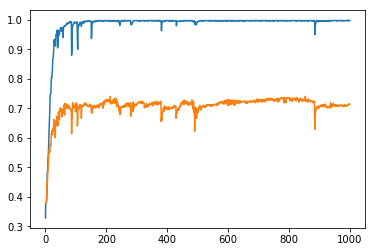

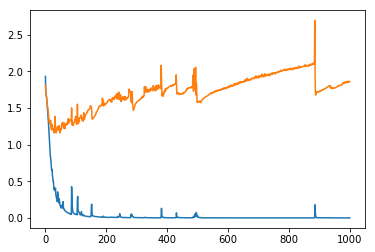

In [213]:
if train:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

In [214]:
# model.save('bilstm.h5')

In [220]:
example

'exam conflict hi based school policy offering additional accommodation option involved club sport conflict exam time staff member time midterm exam may proctored staff member supervising let know would like take accommodation thanks'

In [225]:
model = keras.models.load_model('bilstm.h5')

In [227]:
loss, acc = model.evaluate(X_conv_val, y_conv_val)
print(acc)

456/456 [==============================] - 3s 7ms/step
0.714912280702


In [238]:
def predict_single(sentence):
    x, _ = convert_data(clean_txt([sentence]), ['attendance'], vocabulary, labmap, max_length)
    return {invlabmap[i]:p for i, p in enumerate(model.predict(x)[0])}

predict_single(example)

{'assignments': 8.4552194e-06,
 'attendance': 8.9697755e-07,
 'conflicts': 0.99992311,
 'dsp': 2.3324557e-05,
 'enrollment': 4.7030544e-06,
 'internal': 1.4910102e-05,
 'miscl.': 2.4378367e-05,
 'regrades': 5.9647938e-08}